In [1]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np

In [37]:
base = cv.imread("base.png", cv.IMREAD_GRAYSCALE)

img = cv.imread("base_photo2.png")

escala = 0.007843137
centro_base = (140,135)

K = [[215.6810060961547, 0.0, 376.5], [0.0, 215.6810060961547, 240.5], [0.0, 0.0, 1.0]]

In [22]:
def inverteTransformacao(R, t):
    RInverso = np.transpose(R)

    tInverso  = - np.matmul(RInverso, t)

    return RInverso, tInverso

In [67]:
img = cv.imread("base_photo2.png")

orb = cv.ORB_create()

kp1, des1 = orb.detectAndCompute(base, None)

hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

kerno = np.ones((5,5),"uint8")

#Filtragem da cor amarela
min_amarelo = np.array([20,50,50], np.uint8)
max_amarelo = np.array([40,255,255], np.uint8)
masc_amarelo = cv.inRange(hsv,min_amarelo,max_amarelo)
masc_amarelo = cv.dilate(masc_amarelo,kerno)
res_amarelo = cv.bitwise_and(img,img,mask=masc_amarelo)

#Filtragem da cor azul
min_azul = np.array([99,50,50], np.uint8)
max_azul = np.array([119,255,255], np.uint8)
masc_azul = cv.inRange(hsv,min_azul,max_azul)
masc_azul = cv.dilate(masc_azul,kerno)
masc_azul = cv.dilate(masc_azul,kerno)
res_azul = cv.bitwise_and(img,img,mask=masc_azul)

kp2, des2 = orb.detectAndCompute(res_azul, None)

FLANN_INDEX_LSH = 6
index_params = dict(algorithm = FLANN_INDEX_LSH, table_number = 6, key_size = 12, multi_probe_level = 1)
search_params = dict(checks = 100)

flann = cv.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1,des2,k=2)

good = []
for i,m_n in enumerate(matches):
    if len(m_n) != 2:
        continue
    (m,n) = m_n
    if m.distance < 0.78*n.distance:
        good.append(m)

if(good<4):
    print("aaaa")

#Calcula os pontos da base na imagem
pontoImagem = []

pontoReal = []

#train = kp2
#query = kp1

for match in good:
    point_base = kp1[match.queryIdx].pt
    point_photo = kp2[match.trainIdx].pt

    #Desloca o ponto para o centro de coordenadas do centro da base
    point_baseMetro = [point_base[0]-centro_base[0],point_base[1]-centro_base[1], 0]

    #Converte para metro
    point_baseMetro[0] = point_baseMetro[0] * escala 
    point_baseMetro[1] = point_baseMetro[1] * escala 

    #Adiciona as listas
    pontoImagem.append([point_photo[0],point_photo[1]])
    pontoReal.append(point_baseMetro)

pontoImagem = np.array(pontoImagem, dtype=np.float32)
pontoReal = np.array(pontoReal,dtype=np.float32)
K = np.array(K,dtype=np.float32)

a, RObj, tObj, _ = cv.solvePnPRansac(pontoReal,pontoImagem , K, np.zeros((5,1)))

RObj, _ = cv.Rodrigues(RObj)

RCamera, tCamera = inverteTransformacao(RObj, tObj)

tObj

array([[ -5.98276385],
       [  0.76755538],
       [ 80.95426869]])

In [68]:
good

[&lt;DMatch 0x7faf1394c230&gt;,
 &lt;DMatch 0x7faf1c0f1590&gt;,
 &lt;DMatch 0x7faf1c0f1d70&gt;,
 &lt;DMatch 0x7faf2252ddf0&gt;,
 &lt;DMatch 0x7faf13bb4f90&gt;,
 &lt;DMatch 0x7faf13bb4430&gt;,
 &lt;DMatch 0x7faf227aa310&gt;,
 &lt;DMatch 0x7faf227aa8f0&gt;,
 &lt;DMatch 0x7faf227aaa30&gt;,
 &lt;DMatch 0x7faf227aa230&gt;,
 &lt;DMatch 0x7faf137b5210&gt;,
 &lt;DMatch 0x7faf137b5050&gt;]

&lt;matplotlib.image.AxesImage at 0x7faf135b6ed0&gt;

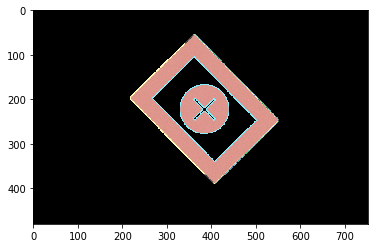

In [62]:
plt.imshow(res_azul)

&lt;matplotlib.image.AxesImage at 0x7faf134e28d0&gt;

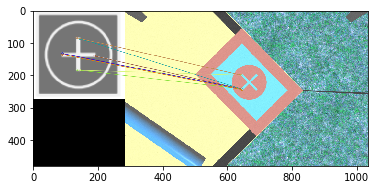

In [69]:
img3 = cv.drawMatches(base, kp1, img, kp2, good, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3)

&lt;matplotlib.image.AxesImage at 0x7faf13bcbb10&gt;

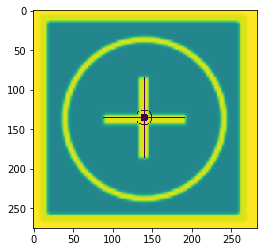

In [20]:
plt.imshow(cv.circle(cv.line(base,centro_base,(140,84),(0,255,255)),centro_base, 5, (0,255,255),thickness=-1))

In [17]:
centro_base

(140, 135)

&lt;matplotlib.image.AxesImage at 0x7f7ba015e6d0&gt;

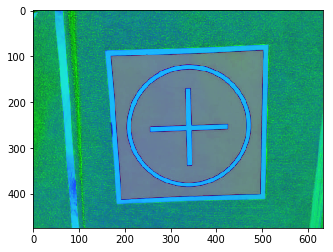

In [81]:
plt.imshow(hsv)

In [79]:
res_amarelo[res_amarelo != 0]

array([], dtype=uint8)